# <u>Count models</u>

Counting is child's play, as easy as 1, 2, 3, right? 

As with most things, the answer's not so simple; some things are easy to count and some things aren't, making some numbers easier to predict than others. What do we do?

1. <font color="darkorchid">**Count what's available**</font> as carefully as possible.
2. Build an appropriate <font color="darkorchid">**probability model**</font> to predict likely outcomes.

To explore this, we'll look at 4 examples of real data:
* cases of chronic medical conditions,
* car crashes in Tennessee,
* births in the United States, and
* coughs in Spain.

We'll see how these relate to 3 fundamental <font color="darkorchid">**count models**</font>:
* binomial models,
* Poisson models, and
* negative binomial models.

Finally, we'll talk about using the <font color="darkorchid">**Kolmogorov-Smirnov test**</font> to check a sample against a reference distribution. 

When we meet again, we'll see how to build better <font color="darkorchid">**regression models for counts**</font> that incorporate predictor variables.


## <u>Imports and settings</u>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import nbinom
from scipy.stats import kstest

In [28]:
# pd.set_option("precision", 4)
sns.set_theme()
plt.rcParams['figure.figsize'] = [15,6]

## <u>Binomial models</u>

### Chronic conditions by age

Here's an important counting problem: given a group of people, how many have a chronic medical condition? Let's see what the 2009 [National Ambulatory Medical Care Survey (NAMCS)](https://www.cdc.gov/nchs/ahcd/index.htm) says:

In [22]:
chronic = pd.read_csv("chronic.csv")
cohorts = pd.read_csv("chronic_cohorts.csv")
cohorts

,Age,Total,Sick,Percentage
0,0,796,21,0.026382
1,1,505,32,0.063366
2,2,320,29,0.090625
3,3,258,37,0.143411
4,4,299,30,0.100334
...,...,...,...,...
96,96,13,12,0.923077
97,97,11,10,0.909091
98,98,6,5,0.833333
99,99,2,1,0.500000


In this dataset, <font color="darkorchid">_Sick_</font> means having at least one of the following conditions:

* arthritis,
* asthma,
* COPD,
* cancer, 
* depression, 
* diabetes, 
* hyperlipidemia,
* hypertension,
* obesity,
* osteoporosis,
* cerebrovascular disease,
* chronic renal failure,  
* congestive heart failure, or 
* ischemic heart disease. 

This is quite a list! The snippet shown corroborates what's expected: older people are more likely to have at least one of these conditions. For example, 30.4% of 25-year-olds have one and 81.43% of the 65-year-olds do:

In [4]:
cohorts[ (cohorts["Age"]==25) | (cohorts["Age"]==65) ]

,Age,Total,Sick,Percentage
25,25,273,83,0.304029
65,65,463,377,0.814255


These percentages are <font color="darkorchid">**empirical probabilities**</font>. Once we have them, what are the chances of having _exactly_ (a) 83 sick people out of 273 25-year-olds and (b) 377 sick people out of 463 65-year-olds? 

### The binomial distribution

If you try something $n$ times with a chance $p$ of <font color="darkorchid">**success**</font> on each <font color="darkorchid">**trial**</font>, the number $Y$ of successes is a <font color="darkorchid">**random variable**</font>: you don't know what the exact outcome will be until it happens, but you know the probability of each possible outcome. In fact, the probability of getting exactly $k$ successes is

$$P( \, Y = k \, ) ~ = ~ \binom{n}{k} \, p^{k} \, (1-p)^{n-k} \ . $$

This is the <font color="darkorchid">**probability mass function (pmf)**</font> for the <font color="darkorchid">**binomial distribution**</font> $B(n,p)$ ; $Y$ is a <font color="firebrick">**binomial random variable**</font>, $Y \sim B(n,p)$.

> **Use the `binom` module from `scipy` (`import`ed above) to work with binomial distributions.**

Based on the NAMCS data, 25-year-olds are like a <font color="darkorchid">**binomial experiment**</font> with $n=273$ and $p=.304029$ ; the chance of observing exactly 83 successes (perverse lingo in this context, I know!) is just over 5% :

In [5]:
p_25 = cohorts["Percentage"][25]
binom.pmf(83,273,p_25)

0.05243020970380286

65-year-olds are like a binomial experiment with 𝑛=463 and 𝑝=.814255 ; the chance of observing exactly 377 successes is just under 5% :

In [6]:
p_65 = cohorts["Percentage"][65]
binom.pmf(377,463,p_65)

0.047625769242453334

Don't be alarmed at these low probabilities &mdash; these are the most likely outcomes! For example:

Text(0.5, 0, '65-year-olds')

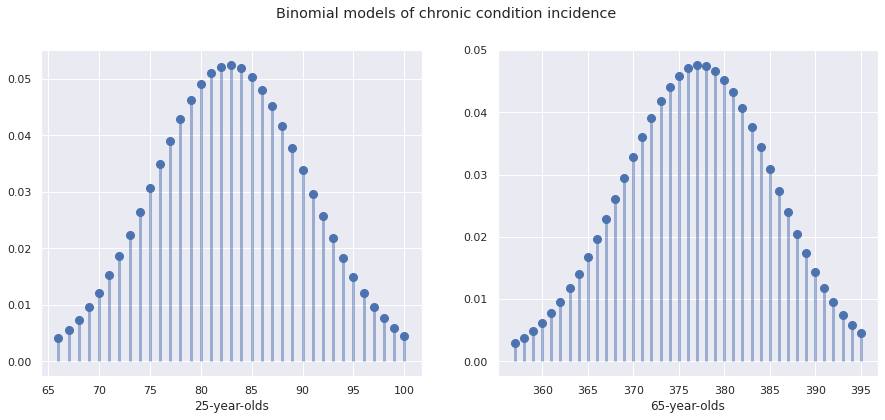

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Binomial models of chronic condition incidence')
x = np.arange(binom.ppf(0.01, 273, p_25), binom.ppf(0.99, 273, p_25))
ax1.plot(x, binom.pmf(x, 273, p_25), 'bo', ms=8)
ax1.vlines(x, 0, binom.pmf(x, 273, p_25), colors='b', lw=3, alpha=0.5)
ax1.set_xlabel('25-year-olds')
x = np.arange(binom.ppf(0.01, 463, p_65), binom.ppf(0.99, 463, p_65))
ax2.plot(x, binom.pmf(x, 463, p_65), 'bo', ms=8)
ax2.vlines(x, 0, binom.pmf(x, 463, p_65), colors='b', lw=3, alpha=0.5)
ax2.set_xlabel('65-year-olds')

It's no accident that these look like normal distributions &mdash; if $n$ is large and/or $p$ is close to $0.5$, $B(n,p)$ is approximately normal with mean $np$ and variance $np(1-p)$ :

$$ B(n,p) \approx N( np, np(1-p) ) \quad \text{for} \quad n \gg 1 \quad \text{or} \quad p \approx 0.5 \ .$$

Turn this around for some quick and dirty calculations. For example, $B(463,.814) \approx N( 377, 70)$, so there will usually be between $377 - 2\sqrt{70} \approx 360 $ and $377 + 2\sqrt{70} \approx 394$ successes, as you can easily check above!

Things are different if $n$ is small and/or $p$ is far from $0.5$. No worries, though &mdash; `binom.pmf` works just fine.

### Binomial logistic regression 

Instead of working separately with each age group &mdash; i.e., each <font color="firebrick">**covariate class**</font> &mdash; we should really construct a <font color="firebrick">**binomial logistic regression model**</font>. Such a model efficiently consolidates the age group percentages to estimate probabilities, as shown here:

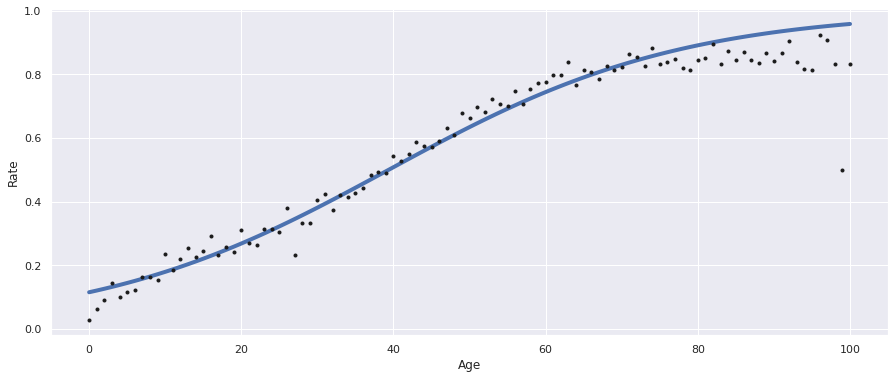

In [30]:
sns.regplot(data=chronic,x="Age", y="Condition",logistic=True, scatter=False,ci=None, line_kws={"lw":"4"})
plt.xlim(-5,105)
plt.ylabel("Rate")
plt.plot( cohorts["Age"], cohorts["Percentage"],'.k');

This particular logistic model, plotted in blue, is <font color="firebrick">**simple**</font> &mdash; it involves only one predictor : 

$$\log{ \left( \text{Odds of a condition} \right) } ~ = ~ -2.04 + .052*\text{Age} \ . $$ 

This model is really a family of binomial distributions, one for each covariate class; each probability is directly related to `Age`. More on this next time!

## <u>Poisson models</u>

### Monthly car crashes 

Here's a different but equally important counting problem: how many traffic accidents are there each month where you live? For my home state of Tennessee, the Department of Transportation provides the relevant data:

In [8]:
crashes = pd.read_csv("TDOT.csv")
crashes

,County,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,Anderson,2010,138,113,169,169,155,152,165,176,178,169,179,152
1,Bedford,2010,71,72,77,70,87,99,90,91,86,118,105,95
2,Benton,2010,21,23,27,32,34,29,16,43,31,50,29,36
3,Bledsoe,2010,5,1,3,3,5,1,7,4,3,6,4,3
4,Blount,2010,126,159,171,145,153,139,201,264,338,267,316,269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,Wayne,2020,23,15,19,27,18,22,20,24,23,18,22,19
1041,Weakley,2020,39,35,40,19,28,43,37,47,54,44,33,21
1042,White,2020,30,31,33,21,50,32,36,46,34,29,42,43
1043,Williamson,2020,394,424,270,170,226,304,312,310,293,405,368,377


In [9]:
meigs = crashes[crashes["County"]=="Meigs"]
meigs = meigs.drop("County",1)
meigs

,Year,January,February,March,April,May,June,July,August,September,October,November,December
60,2010,11,8,10,14,18,12,17,15,16,11,18,14
155,2011,13,14,15,8,13,14,8,14,13,13,14,8
250,2012,12,5,14,11,14,12,16,15,16,15,12,11
345,2013,10,11,15,19,17,6,10,14,19,35,22,12
440,2014,16,16,17,11,16,8,9,13,13,11,17,8
535,2015,10,16,16,14,20,18,16,14,14,19,17,17
630,2016,18,15,17,18,14,14,21,16,9,10,13,16
725,2017,13,12,15,15,12,10,14,9,16,17,19,18
820,2018,14,18,13,10,13,16,12,11,11,12,12,9
915,2019,12,9,6,9,14,20,10,14,9,13,15,11


In [10]:
meigs = meigs.melt( id_vars="Year", var_name="Month", value_name="Crashes" )
meigs

,Year,Month,Crashes
0,2010,January,11
1,2011,January,13
2,2012,January,12
3,2013,January,10
4,2014,January,16
...,...,...,...
127,2016,December,16
128,2017,December,18
129,2018,December,9
130,2019,December,11


In [11]:
meigs.agg( Mean = ("Crashes","mean"), Variance = ("Crashes","var") )

,Crashes
Mean,13.712121
Variance,15.198936


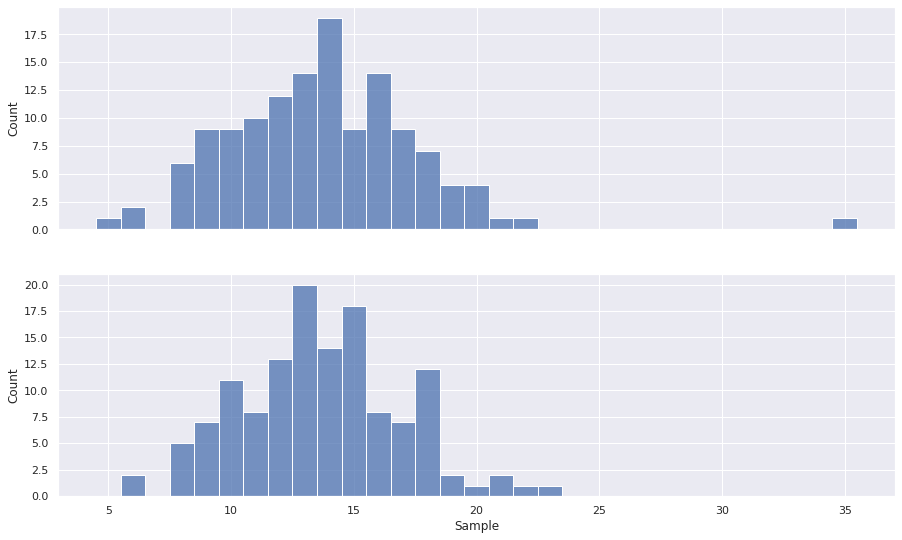

In [12]:
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=meigs, x="Crashes", discrete=True, ax=axs[0])
pois_rv = pd.DataFrame({"Sample" : poisson.rvs( np.mean(meigs["Crashes"]), size=meigs.shape[0])})
sns.histplot(data=pois_rv, x="Sample", discrete=True, ax=axs[1]);

### Monthly births 

by county in the United States (some counties, not others!)


### Poisson distribution

formula for probability distribution 

relationship to/derivation from binomial distribution


### Poisson regression 

used to determine mean rate per county (crashes per month, births per month)


## <u>Negative binomial models</u>

### Monthly car crashes 

by county in Tennessee (some counties, not others!)

### Monthly births 

by county in the United States (some counties, not others!)

### Coughs per hour 

Navarra Hyfe data -- has zeroes!!

### Negative binomial distribution

formula for probability distribution, relationship to Poisson and binomial distributions

### Negative binomial regression 

used to determine mean rates 

## <u>The Kolmogorov-Smirnov test</u>

### Cumulative distribution functions


### The K-S test

check whether empirical observations fit a proposed probability distribution